In [1]:
import praw
import pandas as pd

# 1) Instance of Reddit

In [2]:
user_agent = "praw_scraper"

# Instance of Reddit
reddit = praw.Reddit(
    client_id="xyd-oYB3Q6lX8j9mZKBwIA",
    client_secret="X6tPHoD-LlwFcsPf2eFQovaEPk_59A",
    user_agent=user_agent,
)

# 2) Extracting Reddit posts for Subreddit "nlp"

In [3]:
subreddit_name = "nlp"
subreddit = reddit.subreddit(subreddit_name)

print(subreddit.display_name)

nlp


In [4]:
titles=[]
scores=[]
ids=[]

for submission in subreddit.top(limit=50):
    titles.append(submission.title)
    scores.append(submission.score) #upvotes
    ids.append(submission.id)


In [5]:
df = pd.DataFrame()

df['Title'] = titles
df['Id'] = ids
df['Upvotes'] = scores #upvotes

print(df.head())

                                               Title      Id  Upvotes
0  There should be a HUGE banner saying Neuro Lin...  c31dhf      127
1  This subreddit is about the PSYCHOLOGICAL TECH...  lfhuhu       92
2             6 NLP Techniques You Can Use Right Now  43jhpx       85
3                  Newly certified practitioners....  uxgo2t       67
4  Powerful Hypnotic Language Pattern Everyone Ne...  n4uq7t       60


# 3) Using trained model to do sentiment analysis on Reddit posts

### Setting environment for loading pretrained model

In [6]:
import torch, torchdata, torchtext
from torch import nn

SEED = 1234
torch.manual_seed(SEED)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
from torchtext.datasets import SST2
train = SST2(split='train')

In [9]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_md')

In [10]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):  #data_iter, e.g., train
    for text, _  in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>',
                                                                 '<bos>', '<eos>'])

In [11]:
vocab.set_default_index(vocab["<unk>"]) 

In [12]:
id2word = vocab.get_itos()

In [13]:
pad_idx = vocab['<pad>']

In [14]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

### Creating LSTM Model

In [15]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, 
                 dropout):
        super().__init__()
        #input dim = how many vocab you have
        #emb dim = 300 --> we use fasttext
        #padding_idx tells this lookup table to ignore, and just randomize....
        #<unk>, <bos>, <eos>
        self.embedding_layer = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm            = nn.LSTM(emb_dim,
                                       hid_dim,
                                       num_layers = num_layers,
                                       bidirectional = bidirectional,
                                       dropout = dropout,  #dropout is applied between layers....
                                       batch_first=True)
        
        self.fc              = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, x, lengths):
        #x: [batch size, seq len]
        
        embedded_x = self.embedding_layer(x)
        #x: [batch size, seq len, emb dim]
        
        #pack this embedded_x in such a way that RNN knows to ignore padding....
        #without batch_first = True; things will become [seq len, batch size, emb dim]
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded_x, lengths.to('cpu'),
                                                          enforce_sorted=False,
                                                          batch_first = True
                                                          )
        
        #packed_outputs is basically all hidden states
        #h is the last hidden state
        #c is the last cell state
        packed_outputs, (h, _) = self.lstm(pack_embedded)
        
        #h: [num_layers * num_directions, batch_size, hidden dim]
        
        #it happens that because packed_outputs is all hidden states....some hidden states near the end is
        #hidden state for padding, pytorch guys help you
        #by using this pad_packed_sequence, then all the hidden states will only be not padding....
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first = True)
        #output: [batch size, seq len, direction * hidden sim]
        
        #last hidden state - concat last forward and backward states
        last_hidden_state = torch.cat((h[-1, :, :], h[-2, :, :]), dim = 1)
        #last_hidden_state: [batch_size, hidden_dim * 2]
        
        #for sentiment analysis.....what should i sent to my linear layer...
        return self.fc(last_hidden_state)  #[batch_size, output_dim]==> [batch_size, 4]

In [16]:
input_dim  = 13882
hid_dim    = 256
emb_dim    = 300
output_dim = 2

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.2

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)

### Loading Trainined Model

In [17]:
path = f'models/{model.__class__.__name__}.pt'

In [18]:
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [19]:
if next(model.parameters()).is_cuda:
    model = model.cpu()

# 4) Testing sentiment for each post

In [20]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [21]:
sentiment = []

for title in titles:
    text = torch.tensor(text_pipeline(title))
    text = text.reshape(1, -1)
    text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
    senti_pred = predict(text, text_length)
    sentiment.append(int(senti_pred[0]))

In [22]:
pred = pd.DataFrame()

pred['Title'] = titles
pred['Sentiment'] = sentiment

print(pred)

                                                Title  Sentiment
0   There should be a HUGE banner saying Neuro Lin...          1
1   This subreddit is about the PSYCHOLOGICAL TECH...          1
2              6 NLP Techniques You Can Use Right Now          1
3                   Newly certified practitioners....          1
4   Powerful Hypnotic Language Pattern Everyone Ne...          1
5   This is the sub for NEURO LINGUISTIC PROGRAMMI...          0
6       This subreddit is NOT about machine learning!          0
7                           NLP discussion on YouTube          0
8   Increase the Probability of Achieving Your Out...          1
9   This subreddit is for "Neuro-Linguistic-Progra...          1
10  A Simple Process to Bring More Meaning to Your...          1
11               One thing this NLP sub taught me....          1
12  NLP expert needed: Is anyone watching HBO's "T...          1
13                    The Power of Dis-Identification          1
14                Overcom

### Plot of positive and negative posts count

In [23]:
import matplotlib.pyplot as plt

In [24]:
sentiment_count = {"positive": 0, "negative": 0}
for senti in sentiment:
    if senti == 1:
        sentiment_count["positive"] += 1
    else:
        sentiment_count["negative"] += 1

<BarContainer object of 2 artists>

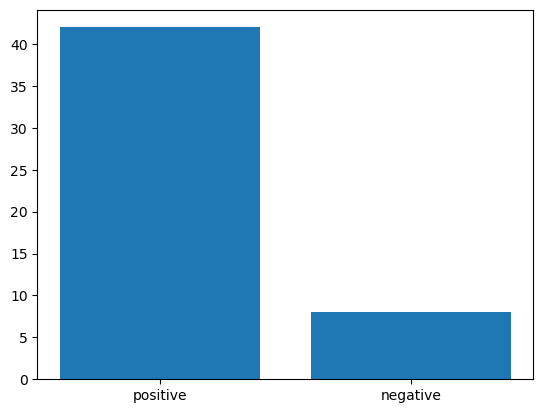

In [25]:
labels = list(sentiment_count.keys())
count  = list(sentiment_count.values())

plt.bar(labels, count)

### Top words inside positive and negative posts

In [26]:
pos_word_count = {}
neg_word_count = {}

def incr_word_count(text, word_count):
    if text in word_count:
        word_count[text] += 1
    else:
        word_count[text] = 1

for idx in range(len(pred)):
    text_list  = tokenizer(pred["Title"][idx])
    senti_pred = pred["Sentiment"][idx]
    
    for text in text_list:
        text = text.lower()
        
        if senti_pred == 1:
            incr_word_count(text, pos_word_count)
        elif senti_pred == 0:
            incr_word_count(text, neg_word_count)

https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value --> sorting dictionary by value

In [27]:
sorted_pos_word_count = dict(sorted(pos_word_count.items(), key=lambda item: item[1]))

In [28]:
sorted_neg_word_count = dict(sorted(neg_word_count.items(), key=lambda item: item[1]))

In [29]:
print("Top words inside positive posts:")
print(list(sorted_pos_word_count.keys())[-5:])

Top words inside positive posts:
['.', 'of', 'to', 'the', 'nlp']


In [30]:
print("Top words inside negative posts:")
print(list(sorted_neg_word_count.keys())[-5:])

Top words inside negative posts:
['this', 'be', 'nlp', 'for', '.']
